# Preprocessing

## Load Data

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import pickle
import seaborn as snsx
import datetime
import math
from tqdm import tqdm
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import skew, norm

pd.set_option('display.max_columns', None) # no truncate columns

In [44]:
# Environment settings
data_path_out = 'Data/output/'
    
# Deserialize previously saved data from "data-visualization"
df = {}
for df_name in ['train', 'test', 'all', 'monthly']:
    with open(data_path_out+df_name+'_dv.obj', 'rb') as file:
        df[df_name] = pickle.load(file)
        
all_data = df['all']
train = df['train']
test = df['test']
monthly_sales = df['monthly']

## Drop features

### Max_Gust_SpeedKm_h

In [45]:
all_data = all_data.drop('Max_Gust_SpeedKm_h', axis=1)
df['train'] = df['train'].drop('Max_Gust_SpeedKm_h', axis=1)
df['test'] = df['test'].drop('Max_Gust_SpeedKm_h', axis=1)

### NumberOfCustomers

In [46]:
for df_name in ['train', 'monthly']:
    df[df_name] = df[df_name].drop('NumberOfCustomers', axis=1)

## Fill missing values

### Events

In [47]:
all_data.Events = all_data.Events.fillna('Normal')
print ('There are {} missing values of Events left'\
       .format(all_data['Events'].isna().sum(),
               all_data['Events'].isna().sum()/all_data.shape[0]*100))

There are 0 missing values of Events left


### Visibility

Since the Visibility has a high negative correlation  with Humidity, a good imputation method could be to group data by Humidity and use the median value to fill in missing values.

Intuitively the minimum visibility corresponds to the maximum humidity and viceversa.

Some humidity levels could not have visiblity values, so a good solution could be to take the mean between the two adiacent values

In [48]:
# Function that replaces missing values of the median with the mean of next and previous values
def replace_nan_median(visdict_list):
    for visdict in visdict_list:
        item_list=[visdict[x] for x in visdict.keys()]
        for val in range(len(item_list)):
            if(math.isnan(item_list[val])):
                prev_val = (val-1) < 0 and item_list[val+1]  or item_list[val-1]
                next_val = (val+1) > len(item_list) and item_list[val-1] or item_list[val+1]
                item_list[val] = float(int((prev_val+next_val)/2))
        iterator = 0
        for k,i in visdict.items():
            visdict[k] = item_list[iterator]
            iterator += 1

# Function that replaces nan in the dataframe with the dictionary
# value corresponding to the samples humidity level
def replace_nan_df(col_name1,col_name2,dictionary):
    nan_index=all_data[all_data[col_name1].isnull()].index.tolist()
    for index in tqdm(nan_index):
        humidty_lvl = all_data.loc[index,col_name2] 
        all_data.loc[index,col_name1] = dictionary[humidty_lvl]

In [49]:
min_vis_dict = all_data.groupby('Max_Humidity')['Min_VisibilitykM'].apply(lambda x: x.median()).to_dict()
max_vis_dict = all_data.groupby('Min_Humidity')['Max_VisibilityKm'].apply(lambda x: x.median()).to_dict()
mean_vis_dict = all_data.groupby('Mean_Humidity')['Mean_VisibilityKm'].apply(lambda x: x.median()).to_dict()
        
replace_nan_median([min_vis_dict,max_vis_dict,mean_vis_dict])

#Replacing nan in dataframe 
replace_nan_df('Min_VisibilitykM', 'Max_Humidity', min_vis_dict)
replace_nan_df('Max_VisibilityKm', 'Min_Humidity', max_vis_dict)
replace_nan_df('Mean_VisibilityKm', 'Mean_Humidity', mean_vis_dict)

for col in ["Min_VisibilitykM", "Max_VisibilityKm", "Mean_VisibilityKm"]:
    print ("There are {} missing values of {} left".
           format(all_data[col].isna().sum(),col))
os.system('say "Visibility Done."')

100%|██████████| 13959/13959 [00:44<00:00, 313.55it/s]


There are 0 missing values of Min_VisibilitykM left
There are 0 missing values of Max_VisibilityKm left
There are 0 missing values of Mean_VisibilityKm left


0

### Cloud Cover

In [50]:
rf = RandomForestClassifier(n_estimators=50, verbose=True)

# enable or not cross validation
cv_mode = False

cloud_data = all_data.copy()
cloud_data = pd.get_dummies(cloud_data)
cloud_data['Date_delta'] = (cloud_data['Date'] - cloud_data['Date'].min()) / np.timedelta64(1, 'D')
cloud_data = cloud_data.drop('Date', axis=1)
nan_indexes = cloud_data[cloud_data['CloudCover'].isnull()].index.tolist()
good_indexes = cloud_data[~cloud_data['CloudCover'].isnull()].index.tolist()

train_cloud = cloud_data.loc[good_indexes]
test_cloud = cloud_data.loc[nan_indexes]
print(train_cloud.shape)
print(test_cloud.shape)

X_train_cloud = train_cloud.copy()
X_train_cloud = X_train_cloud.drop(['CloudCover'], axis=1)
y_train_cloud = train_cloud['CloudCover']
test_cloud = test_cloud.drop('CloudCover',axis=1)

scaler = RobustScaler()
X_train_cloud = scaler.fit_transform(X_train_cloud)
test_cloud = scaler.transform(test_cloud)

if(cv_mode):
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(X_train_cloud)
    score_CV = cross_val_score(rf, X_train_cloud, y_train_cloud, cv=kf)

    print("The 10-fold crossvalidation of RF is {:.5f} +/- {:.3f}".format(score_CV.mean(),score_CV.std()))
    os.system('say "Crossvalidation done."')

(519111, 69)
(49599, 69)


In [51]:
rf.fit(X_train_cloud,y_train_cloud)
pred_results = rf.predict(test_cloud)
nan_index = cloud_data[cloud_data['CloudCover'].isnull()].index.tolist()
result_df = pd.DataFrame(data={'Index' : nan_index,
                               'CloudCover': pred_results}).set_index('Index')
#replace missing values
for i in tqdm(nan_index):
    all_data.loc[i,'CloudCover'] = result_df.loc[i,'CloudCover']

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
100%|██████████| 49599/49599 [02:00<00:00, 412.14it/s]


## Missing day
Missing day 2016-03-03 in the whole in dataset. It has been decided to ignore it since it wouldn't affect much the prediction.

In [52]:
all_data[all_data.Date == '2016-03-03'].shape[0]

0

## Region 2 missing values
Fill missing data in datetime range 2017-07-04/2018-01-03 (extremes included).

### Analisys of missing dates window

In [11]:
# Missing window data from store 1004 from Region 2
all_data[all_data.StoreID == 1004].loc[(all_data.Date >= '2017-07-02') & (all_data.Date <= '2018-01-05')]

,StoreID,Date,IsHoliday,IsOpen,HasPromotions,StoreType,AssortmentType,NearestCompetitor,Region,Region_AreaKM2,Region_GDP,Region_PopulationK,CloudCover,Events,Max_Dew_PointC,Max_Humidity,Max_Sea_Level_PressurehPa,Max_TemperatureC,Max_VisibilityKm,Max_Wind_SpeedKm_h,Mean_Dew_PointC,Mean_Humidity,Mean_Sea_Level_PressurehPa,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees
3403,1004,2017-07-02,False,False,False,Hyper Market,General,11805,2,32221,16186,5727,7.0,Rain,15,94,1013,17,10.0,27,13,92,1012,14,9.0,14,11,88,1010,12,5.0,0.0,217
3404,1004,2017-07-03,False,True,True,Hyper Market,General,11805,2,32221,16186,5727,5.0,Rain-Thunderstorm,13,94,1019,17,10.0,26,11,85,1015,13,10.0,14,9,63,1013,11,4.0,0.0,260
3405,1004,2018-01-04,True,False,False,Hyper Market,General,11805,2,32221,16186,5727,5.0,Fog,-2,100,1036,0,6.0,11,-5,95,1035,-5,2.0,6,-10,80,1034,-10,0.0,0.0,232
3406,1004,2018-01-05,False,True,False,Hyper Market,General,11805,2,32221,16186,5727,7.0,Fog-Rain,2,100,1034,3,10.0,35,-3,96,1031,-4,6.0,11,-12,87,1029,-11,1.0,0.0,243


In [12]:
# Compare size of the dataset with a store without missing window date
print('''Size of the dataset of a store:
- from region 2: {}
- from another region: {}

total missing: {}'''
      .format(all_data[all_data.StoreID == 1004].shape[0],
              all_data[all_data.StoreID == 1006].shape[0],
             all_data[all_data.StoreID == 1006].shape[0]-all_data[all_data.StoreID == 1004].shape[0]))

Size of the dataset of a store:
- from region 2: 606
- from another region: 790

total missing: 184


### Window dates filling

In [13]:
# create date range dataframe
date_missing_start = '2017-07-04'
date_missing_end = '2018-01-03'

date_range = pd.date_range(date_missing_start, date_missing_end)

# create df and set dtypes
df_region2 = pd.DataFrame(data={'Date': date_range, 'Region': '2'})

df_region2.Date = pd.to_datetime(df_region2.Date)
df_region2.Region = df_region2.Region.astype('category')

print(df_region2.shape)
df_region2.head()

(184, 2)


,Date,Region
0,2017-07-04,2
1,2017-07-05,2
2,2017-07-06,2
3,2017-07-07,2
4,2017-07-08,2


#### Replacement by similar store

In [14]:
# HasPromotions (replacement with store 1006 since all are equal)
df_region2['HasPromotions'] = all_data[all_data.StoreID == 1006]\
.loc[(all_data.Date >= date_missing_start) & (all_data.Date <= date_missing_end)]\
.HasPromotions.reset_index().drop('index', axis=1)

#### Replacement by most correlated region

In [15]:
# Group all_data by Region
dic_all = {
    'IsHoliday': 'mean',
    'IsOpen': 'mean',
    'HasPromotions': 'mean',
    'NearestCompetitor': 'mean',
    'Region_AreaKM2': 'mean',
    'Region_GDP': 'mean',
    'Region_PopulationK': 'mean',
    'CloudCover': 'mean',
    'Max_Humidity': 'mean',
    'Max_Dew_PointC': 'mean',
    'Max_Sea_Level_PressurehPa': 'mean',
    'Max_TemperatureC': 'mean',
    'Max_VisibilityKm': 'mean',
    'Max_Wind_SpeedKm_h': 'mean',
    'Mean_Dew_PointC': 'mean',
    'Mean_Humidity': 'mean',
    'Mean_Sea_Level_PressurehPa': 'mean',
    'Mean_TemperatureC': 'mean',
    'Mean_VisibilityKm': 'mean',
    'Mean_Wind_SpeedKm_h': 'mean',
    'Min_Dew_PointC': 'mean',
    'Min_Humidity': 'mean',
    'Min_Sea_Level_PressurehPa': 'mean',
    'Min_TemperatureC': 'mean',
    'Min_VisibilitykM': 'mean',
    'Precipitationmm': 'mean',
    'WindDirDegrees': 'mean'}


# Define train_data grouped by Region in common date range
all_data_byRegion = all_data.groupby(['Region', pd.Grouper(key='Date', freq='D')])\
.agg(dic_all).reset_index()

all_data_common_byRegion =\
all_data_byRegion.loc[(all_data_byRegion.Date >= '2016-03-01') &
                      (all_data_byRegion.Date <= '2017-07-03')]

all_data_missing_byRegion =\
all_data_byRegion[all_data_byRegion.Region != '2']\
.loc[(all_data_byRegion.Date >= date_missing_start) &
     (all_data_byRegion.Date <= date_missing_end)]

# Define train_data grouped by Region in common date range
all_data_byRegion_except_region2 = all_data_common_byRegion[all_data_common_byRegion.Region != '2']
all_data_byRegion_except_region2.Region.cat.remove_unused_categories(inplace=True)

In [16]:
# Replace by most correlated region
median_correction = ['Max_TemperatureC', 'CloudCover', 'Max_Sea_Level_PressurehPa',
                     'Max_Wind_SpeedKm_h', 'Max_Dew_PointC', 'WindDirDegrees',
                     'Mean_Dew_PointC', 'Mean_Sea_Level_PressurehPa', 'Mean_TemperatureC',
                     'Mean_Wind_SpeedKm_h', 'Min_Dew_PointC', 'Min_Sea_Level_PressurehPa',
                     'Min_VisibilitykM']

print('Most correlated region for the given feature')
print('{:<30}{:10}{:>10}'.format('FEATURE', 'REGION', 'CORRELATION'))
print('-' * (30+10+10))

# get the date range
for feature_name in median_correction:
    # compute correlation for each region wrt region 2 for current feature
    corr_byRegion = {}
    for region_name, region in all_data_byRegion_except_region2.groupby('Region'):
        region = region[feature_name]
        region_2 = all_data_common_byRegion[feature_name][all_data_common_byRegion.Region == '2']
        
        corr_byRegion[region_name] = pd.np.corrcoef(region_2, region)[1,0]
    
    # get region with max correlation for the current feature
    max_corr_region = max(corr_byRegion, key=corr_byRegion.get)
    
    print('{:<30}{:10}{:10.4f}'.format(feature_name, max_corr_region, corr_byRegion[max_corr_region]))
    
    # replace missing feature for date window with most correlated region feature 
    feature_column = all_data_missing_byRegion[all_data_missing_byRegion.Region == max_corr_region]\
    [feature_name].reset_index().drop('index', axis=1)
    
    df_region2 = pd.concat([df_region2, feature_column], axis=1)

Most correlated region for the given feature
FEATURE                       REGION    CORRELATION
--------------------------------------------------
Max_TemperatureC              6             0.9603
CloudCover                    1             0.5218
Max_Sea_Level_PressurehPa     6             0.9825
Max_Wind_SpeedKm_h            6             0.6525
Max_Dew_PointC                6             0.9609
WindDirDegrees                6             0.5041
Mean_Dew_PointC               6             0.9597
Mean_Sea_Level_PressurehPa    6             0.9892
Mean_TemperatureC             6             0.9668
Mean_Wind_SpeedKm_h           6             0.7335
Min_Dew_PointC                6             0.9249

/Users/yannickgiovanakis/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yannickgiovanakis/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]



Min_Sea_Level_PressurehPa     6             0.9816
Min_VisibilitykM              6             0.3587


#### Replacement by region 2 itself

In [17]:
# copy from Region 2: Region_AreaKM2, Region_GDP, Region_PopulationK
for feature_name in ['Region_AreaKM2', 'Region_GDP', 'Region_PopulationK']:
    df_region2[feature_name] = all_data[all_data.Region == '2'][feature_name].unique()[0]

#### Replacement by single store from Region 2 and concatenation with dataset

In [18]:
# Add missing dates window to dataset
print(all_data.shape)

# add to all_data missing region 2 values
for storeid in all_data[all_data.Region == '2'].StoreID.unique():    
    # copy from same stores from Region 2: StoreID, AssortmentType, NearestCompetitor, StoreType
    store_data = {
        'StoreID': np.array([storeid], dtype='uint16'),
        'AssortmentType': all_data[all_data.StoreID == storeid].AssortmentType.unique()[0],
        'NearestCompetitor': all_data[all_data.StoreID == storeid].NearestCompetitor.unique()[0],
        'StoreType': all_data[all_data.StoreID == storeid].StoreType.unique()[0]
    }
    
    # create 'storeid' column
    df_storeid = pd.DataFrame(data=store_data, index=np.arange(0, df_region2.shape[0]))
    
    df_storeid = pd.concat([df_region2, df_storeid], axis=1)
    
    # add to all_data df the missing values range for 'storeid'
    all_data = pd.concat([all_data, df_storeid], axis=0, ignore_index=True, sort=True)

all_data = all_data\
.sort_values(by=['Region', 'StoreID', 'Date'], ascending=[False, False, True])\
.reset_index().drop('index', axis=1)

print(all_data.shape)

(568710, 33)
(591710, 33)


In [19]:
all_data['IsHoliday']=all_data['IsHoliday'].astype('bool')
all_data['IsOpen']=all_data['IsOpen'].astype('bool')
all_data['AssortmentType']=all_data['AssortmentType'].astype('category')
all_data['StoreType']=all_data['StoreType'].astype('category')
all_data['Region']=all_data['Region'].astype('category')
all_data['Events']=all_data['Events'].astype('category')

In [20]:
print('TODO:')
all_data[all_data.Region == '2'].isna().any()
all_data.info()

TODO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591710 entries, 0 to 591709
Data columns (total 33 columns):
AssortmentType                591710 non-null category
CloudCover                    591710 non-null float32
Date                          591710 non-null datetime64[ns]
Events                        568710 non-null category
HasPromotions                 591710 non-null bool
IsHoliday                     591710 non-null bool
IsOpen                        591710 non-null bool
Max_Dew_PointC                591710 non-null int8
Max_Humidity                  568710 non-null float64
Max_Sea_Level_PressurehPa     591710 non-null uint16
Max_TemperatureC              591710 non-null int8
Max_VisibilityKm              568710 non-null float32
Max_Wind_SpeedKm_h            591710 non-null uint8
Mean_Dew_PointC               591710 non-null int8
Mean_Humidity                 568710 non-null float64
Mean_Sea_Level_PressurehPa    591710 non-null uint16
Mean_TemperatureC             59

## New Features

### Store is open and is holiday
This feature has been added for those stores that are open during holidays: we want to inspect if the sales are higher in those days

In [53]:
is_open_holiday = all_data.IsHoliday & all_data.IsOpen
all_data['Hol_and_open'] = is_open_holiday

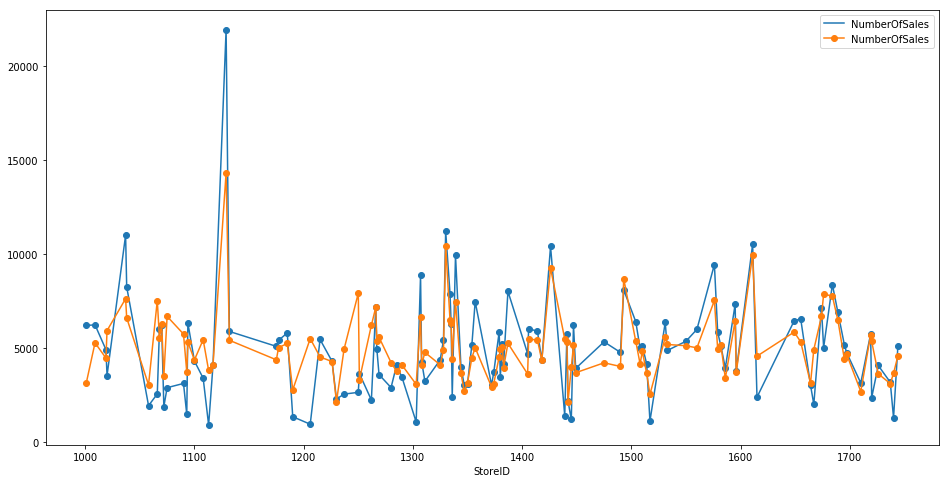

In [54]:
# For plotting reasons
holidays_open_mask = train.IsHoliday & train.IsOpen
open_mask = train['IsOpen'] == True
not_holidays_mask =  train['IsHoliday'] == False
not_holidays_open_mask = not_holidays_mask & open_mask

df_holidays_open = train[holidays_open_mask].groupby("StoreID")
avg_sales_holidays = df_holidays_open.NumberOfSales.mean()
avg_sales_holidays.plot(figsize=(16,8),legend=True,marker='o')

df_not_holidays_open = train[not_holidays_open_mask].groupby("StoreID")
avg_sales_not_holidays = df_not_holidays_open.NumberOfSales.mean()
avg_sales_not_holidays = avg_sales_not_holidays.filter(items = avg_sales_holidays.index)
avg_sales_not_holidays.plot(figsize=(16,8),legend=True,marker='o');

### Region's population density

In [55]:
all_data['Region_PD'] = all_data.Region_PopulationK.div(all_data.Region_AreaKM2, axis=0)

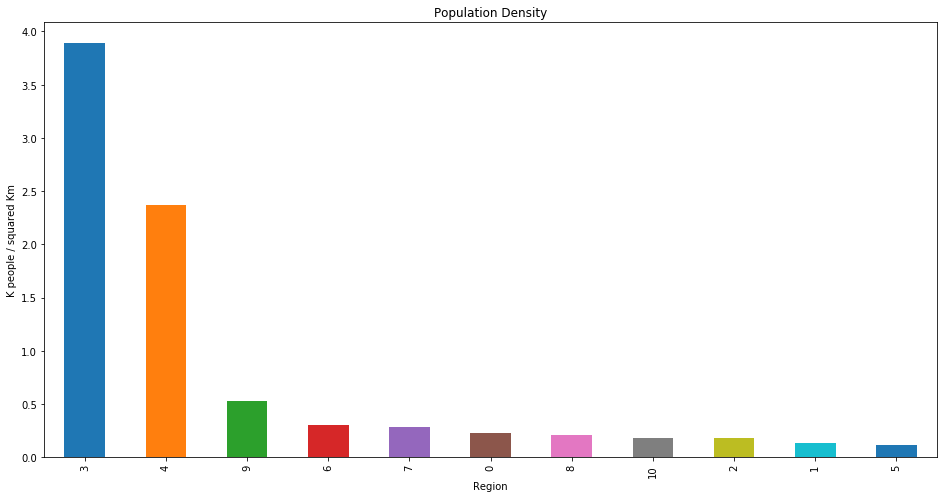

In [56]:
plot_PD = all_data.groupby("Region").Region_PD.mean().sort_values(ascending=False)\
        .plot(kind='bar', title='Population Density', figsize=(16,8));
plot_PD.set_ylabel("K people / squared Km");

## Seasonality features

In [57]:
# obtain weeks
weeks = all_data[['Date']].groupby(pd.Grouper(key='Date', freq='W')).sum().reset_index()

# MUST BE FIXED!!
# all_data['week_of_month'] = (weeks.Date.dt.day - 1) // 7 + 1 # number of the week in the month

all_data['year'] = all_data.Date.dt.year
all_data['month'] = all_data.Date.dt.month
all_data['day_of_month'] = all_data.Date.dt.day
all_data['day_of_week'] = all_data.Date.dt.dayofweek
all_data['day_of_year'] = all_data.Date.dt.dayofyear
all_data['WeekOfYear'] = all_data.Date.dt.weekofyear
all_data['days_in_month'] = all_data.Date.dt.daysinmonth

## One-Hot encoding

In [58]:
all_data_reg_temp = all_data['Region']
all_data = pd.get_dummies(all_data,columns=['Region','AssortmentType', 'StoreType', 'Events'])
all_data['Region'] = all_data_reg_temp

## New Features Holidays

In [59]:
def num_of_features(regional_week_year, week, year, column_of_interest):
    num_holidays = 0

    if week == 1:
        week_before = [52,year-1]
        week_after = [2,year]
    if week == 52:
        week_after = [1,year+1]
        week_before = [51,year]
    if (week>1) & (week<52):
        week_before = [week-1,year]
        week_after = [week+1,year]
    
    before_df = regional_week_year[(regional_week_year['WeekOfYear']==week_before[0])&
                                  (regional_week_year['year']==week_before[1])]
    
    after_df = regional_week_year[(regional_week_year['WeekOfYear']==week_after[0])&
                                  (regional_week_year['year']==week_after[1])]
    this_df = regional_week_year[(regional_week_year['WeekOfYear']==week)&
                                 (regional_week_year['year']==year)]
    
    num_ago = before_df[before_df[column_of_interest]][column_of_interest].sum()
    num_next = after_df[after_df[column_of_interest]][column_of_interest].sum()
    num_this = this_df[this_df[column_of_interest]][column_of_interest].sum()
    
    return num_ago, num_next, num_this

def create_new_features(before,current,after,column_of_interest):
    all_data[before] = 0
    all_data[current] = 0
    all_data[after] = 0

    region_list= ["Region_"+str(d) for d in range(0,11)]
    for region in tqdm(region_list):
        curr_region = all_data[all_data[region]==1]

        #get all valid dates of that region
        regional_week_year=curr_region[['WeekOfYear','year',column_of_interest]]

        #get all store ids of that region
        regional_stores=len(curr_region['StoreID'].unique())

        week_year_list =regional_week_year[['WeekOfYear','year']].drop_duplicates().values.tolist()

        for date in week_year_list:
            num_ago,num_next,num_this = num_of_features(regional_week_year,
                                                        date[0],
                                                        date[1],
                                                        column_of_interest)

            all_data.at[((all_data['WeekOfYear']==date[0])&
                         (all_data['year']==date[1])),before]=int(num_ago/regional_stores)
            all_data.at[((all_data['WeekOfYear']==date[0])&
                         (all_data['year']==date[1])),after]=int(num_next/regional_stores)
            all_data.at[((all_data['WeekOfYear']==date[0])&
                         (all_data['year']==date[1])),current]=int(num_this/regional_stores)

In [60]:
create_new_features('HolidaysWeekBefore', 'HolidaysWeekCurrent', 'HolidaysWeekAfter','IsHoliday')
create_new_features('PromoWeekBefore', 'PromoWeekCurrent', 'PromoWeekAfter', 'HasPromotions')

100%|██████████| 11/11 [01:32<00:00,  8.45s/it]


## Split train and test

In [61]:
train_final = all_data[:train.shape[0]].copy()
train_final['NumberOfSales'] = train.NumberOfSales
train_final['NumberOfCustomers'] = train.NumberOfSales

# extract the test examples (we don't have the class value for this)
test_final = all_data[train.shape[0]:]

## Add differential feature (on train set)

In [ ]:
march_2016  = datetime.date(2016,3,31)
monthly_sales['Differential'] = 0        
        
for storeID, store in tqdm(monthly_sales.groupby('StoreID')):
    monthly_sales.loc[store.index,'one_step'] = store['NumberOfSales'].shift(1).fillna(0)
    monthly_sales.loc[store.index,'two_steps'] = store['NumberOfSales'].shift(2).fillna(0)

100%|██████████| 749/749 [00:02<00:00, 346.82it/s]


In [ ]:
train_final['Differential'] = 0

#correct one step in april
april_mask = monthly_sales.Date.dt.month == 4
year_mask = monthly_sales.Date.dt.year == 2016
monthly_sales.loc[year_mask & april_mask,'one_step'] = 0

#compute differential
monthly_sales['Differential'] = monthly_sales['one_step'] - monthly_sales['two_steps']
pippo = monthly_sales[['StoreID','Date','Differential']]

#longest for ever - more than 10 mins - there must be a better way..
for index,row in tqdm(pippo.iterrows()):
    differential = row.Differential
    month = row.Date.month
    year = row.Date.year
    store = row.StoreID
    month_mask = train_final.Date.dt.month == month
    year_mask = train_final.Date.dt.year == year
    store_mask = train_final.StoreID == store
    
    train_final.loc[store_mask & year_mask & month_mask,'Differential'] = differential


4753it [05:20, 14.83it/s]

## Save Train and Test

In [ ]:
# train_final.to_csv(data_path_out+'train_final.csv')
# test_final.to_csv(data_path_out+'test_final.csv')

# Serialize dataframes for later use in implementations
with open(data_path_out+'train_pp.obj', 'wb') as file:
        pickle.dump(train_final, file)
# with open(data_path_in+'test_pp.obj', 'wb') as file:
#         pickle.dump(test_clean, file)